In [1]:
from model import BERT4NILM
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def cutoff_energy(data, cutoff):

    data[data < 5] = 0
    tmp = np.full(shape=(data.shape[0],),fill_value=cutoff)

    data = np.minimum(data,tmp)
    
    return data

def find_nonzero_runs(a):
    # Create an array that is 1 where a is nonzero, and pad each end with an extra 0.
    isnonzero = np.concatenate(([0], (np.asarray(a) != 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(isnonzero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

#Func that fuse together  near intervals that are close n_timesteps=gap
def zeros_interval(data, intervals, gap):
    i=0

    for i, interval in enumerate(intervals):
            if interval[1]-interval[0]<= gap:
                data[interval[0]:interval[1]] = 0 

def compute_status(data, threshold, min_on):  
    # sourcery skip: inline-immediately-returned-variable
    status = (data >= threshold) * 1
    interval = find_nonzero_runs(status)
    if interval is not None:
        zeros_interval(data, interval, min_on)
    return status

#da guardare



def padding_seqs(in_array, window_size):
    if len(in_array) == window_size:
        return in_array
    try:
        out_array = np.zeros((window_size, in_array.shape[1]))
    except:
        out_array = np.zeros(window_size)

    length = len(in_array)
    out_array[:length] = in_array
    return out_array

def standardize_data(data, mu=0.0, sigma=1.0):
    data = data-mu
    data /= sigma
    return data
def de_standardize_data(data, mu=0.0, sigma=1.0):
    data *= sigma
    data = data+mu
    return data

from sklearn.metrics import confusion_matrix
import numpy as np
import os
import json
def acc_precision_recall_f1_score(pred, status):
    assert pred.shape == status.shape

    pred = pred.reshape(-1, pred.shape[-1])
    status = status.reshape(-1, status.shape[-1])
    accs, precisions, recalls, f1_scores = [], [], [], []

    for i in range(status.shape[-1]):
        tn, fp, fn, tp = confusion_matrix(status[:, i], pred[:, i], labels=[
                                          0, 1]).ravel()
        acc = (tn + tp) / (tn + fp + fn + tp)
        precision = tp / np.max((tp + fp, 1e-9))
        recall = tp / np.max((tp + fn, 1e-9))
        f1_score = 2 * (precision * recall) / \
            np.max((precision + recall, 1e-9))

        accs.append(acc)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)

    return np.array(accs), np.array(precisions), np.array(recalls), np.array(f1_scores)

def relative_absolute_error(pred, label):
    assert pred.shape == label.shape

    pred = pred.reshape(-1, pred.shape[-1])
    label = label.reshape(-1, label.shape[-1])
    temp = np.full(label.shape, 1e-9)
    relative, absolute, sum_err = [], [], []

    for i in range(label.shape[-1]):
        relative_error = np.mean(np.nan_to_num(np.abs(label[:, i] - pred[:, i]) / np.max(
            (label[:, i], pred[:, i], temp[:, i]), axis=0)))
        absolute_error = np.mean(np.abs(label[:, i] - pred[:, i]))

        relative.append(relative_error)
        absolute.append(absolute_error)

    return np.array(relative), np.array(absolute)

def Wh_estimate(pred, label, f_sampling):
    assert pred.shape == label.shape
    label_p = np.sum(label, axis=0)/(3600*f_sampling)
    pred_p = np.sum(pred, axis=0)/(3600*f_sampling)
    pred_percentage = pred_p/label_p
    return pred_percentage, label_p
    
def log_data_and_images(path,aggregate,pred,labels,f_sampling,appliances,args,show=False):
    for i in appliances:
        path = f"{path}_{i}"
    if len(pred.shape) == 1:
        pred = np.expand_dims(pred,-1)

    if len(labels.shape) == 1:
        labels = np.expand_dims(labels,-1)

    if len(aggregate.shape) == 2:
        aggregate = np.squeeze(aggregate, axis=-1)

    status_l = (labels>=5)*1
    status_p = (pred>=5)*1

    print(pred.shape)
    print(labels.shape)
    print(status.shape)
    print(aggregate.shape)
    assert pred.shape == labels.shape
    assert aggregate.shape[0] == pred.shape[0]

    if os.path.exists(path):

        if len(os.listdir(path)) == 0:
            pass
        else:
            print("found a non empty directory")    
            return
    else:
        os.makedirs(path)
    acc, precision, recall, f1_score = acc_precision_recall_f1_score(status_p, status_l)
    rel_error, abs_error = relative_absolute_error(pred, labels)
    wh_percentage, wh_label = Wh_estimate(pred, labels, f_sampling)
    metrics = { 'appliances': list(appliances),
                'accuracy': list(acc),
                "precision":list(precision),
                "recall":list(recall),
                "f1_score":list(f1_score),
                "relative_error":list(rel_error),
                "absolute_error":list(abs_error),
                "tot_appl_wh": list(wh_label),
                "predicted_percentage":list(wh_percentage)
                }
    print(metrics)
    for i, appl in enumerate(appliances):
        plt.figure(figsize=(50, 10))

        plt.title(f'Appliance {appl}')
        plt.plot(range(aggregate.shape[0]), aggregate[:], label='Aggregate')
        plt.plot(range(aggregate.shape[0]), labels[:, i], label='Ground truth')
        plt.plot(range(aggregate.shape[0]), pred[:, i], label='Prediction')
        plt.legend()
        plt.savefig(os.path.join(path, f"{appl}.png"))
        if show:
            plt.show()
    with open(os.path.join(path,"metrics.json"), 'w') as outfile:
        json.dump(metrics, outfile)
    with open(os.path.join(path,"parameters.json"), 'w') as outfile:
        json.dump(args, outfile)
        

In [3]:
class args:pass
args_dict = {}
args_dict["trained_on"] = "uk_dale"
args_dict["tested_on"] = "synd"
args_dict["cutoff"] = args.cutoff = 2500
args_dict["threshold"] =args.threshold = 20
args_dict["min_on"] =args.min_on = 10
args_dict["window_size"] =args.window_size = 480
args_dict["drop_out"] =args.drop_out = 0.1
args_dict["output_size"] =args.output_size = 1
args_dict["stride"] =args.stride =160
args_dict["mul"] =args.mul = int(((args.window_size/args.stride)-1)/2)
model = BERT4NILM(args)
print(model)
model.float()
model.load_state_dict(torch.load('/home/franzhd/BERT4NILM/experiments/uk_dale/dishwasher/best_acc_model.pth'))

BERT4NILM(
  (conv): Conv1d(1, 256, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=replicate)
  (pool): LPPool1d(norm_type=2, kernel_size=2, stride=2, ceil_mode=False)
  (position): PositionalEmbedding(
    (pe): Embedding(240, 256)
  )
  (layer_norm): LayerNorm()
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadedAttention(
        (linear_layers): ModuleList(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
        (output_linear): Linear(in_features=256, out_features=256, bias=True)
        (attention): Attention()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): PositionwiseFeedForward(
        (w_1): Linear(in_features=256, out_features=1024, bias=True)
        (w_2): Linear(in_features=1024, ou

<All keys matched successfully>

In [4]:
x = np.load('/home/franzhd/LIT_BE_ML/data/dw_6sec/main.npy')  
y = np.load('/home/franzhd/LIT_BE_ML/data/dw_6sec/dw.npy')

In [5]:
# tmp = x -y
# plt.plot(range(14400), tmp[:14400])
# tmp = tmp +y*3
# plt.plot(range(14400), tmp[:14400])
# x =tmp

In [6]:
fridge_mean = np.mean(y*3)
mean = np.mean(x)
std = np.std(x)
x = x[:14400]
print(x.shape)
#x = standardize_data(x, np.mean(x), np.std(x))


(14400, 1)


In [7]:
print(model)

BERT4NILM(
  (conv): Conv1d(1, 256, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=replicate)
  (pool): LPPool1d(norm_type=2, kernel_size=2, stride=2, ceil_mode=False)
  (position): PositionalEmbedding(
    (pe): Embedding(240, 256)
  )
  (layer_norm): LayerNorm()
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadedAttention(
        (linear_layers): ModuleList(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
        (output_linear): Linear(in_features=256, out_features=256, bias=True)
        (attention): Attention()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): PositionwiseFeedForward(
        (w_1): Linear(in_features=256, out_features=1024, bias=True)
        (w_2): Linear(in_features=1024, ou

In [8]:
#select one day (14400,1)

In [9]:
tmpp = np.arange(0, x.shape[0],args.stride)
print(tmpp.shape)

(90,)


In [10]:
model.eval()
energy_res = []
status_res = []
for i in tqdm(np.arange(0, x.shape[0],args.stride)):

    seqs = padding_seqs(x[i:i+args.window_size], args.window_size)
    
    # if np.mean(seqs)-np.std(seqs) > 1000:
    #     seqs=seqs - 1000
    seqs = standardize_data(seqs, mean, std)
    seqs = np.reshape(seqs,(1,1,args.window_size))washing_machinestride])
        status_res.append(logits_status[:(args.mul+1)*args.stride])
    else:
        energy_res.append(logits_energy[+args.mul*args.stride:-args.mul*args.stride])
        status_res.append(logits_status[+args.mul*args.stride:-args.mul*args.stride])
    
    

100%|██████████| 90/90 [00:00<00:00, 135.19it/s]


In [11]:
print(len(energy_res))
print(energy_res[1].shape)


90
(160,)


In [12]:
energy = np.concatenate(energy_res)
status = np.concatenate(status_res)
print(energy.shape)
print

(14560,)


<function print>

In [13]:
#energy = de_standardize_data(energy, mean,std)
# # energy = cutoff_energy(energy , float(cutoff_fridge))
# # status = compute_status(energy, float(threshold))
# energy = energy 
# print(energy.shape)

In [14]:
#x = de_standardize_data(x, mean,std)

(14400, 1)
(14400, 1)
(14560,)
(14400,)
{'appliances': ['dish_washer'], 'accuracy': [0.8660416666666667], 'precision': [0.1054921152800435], 'recall': [0.40585774058577406], 'f1_score': [0.16745791972378074], 'relative_error': [0.1489460035976622], 'absolute_error': [61.40816382853193], 'tot_appl_wh': [842.3344371888888], 'predicted_percentage': [0.8090466382120362]}


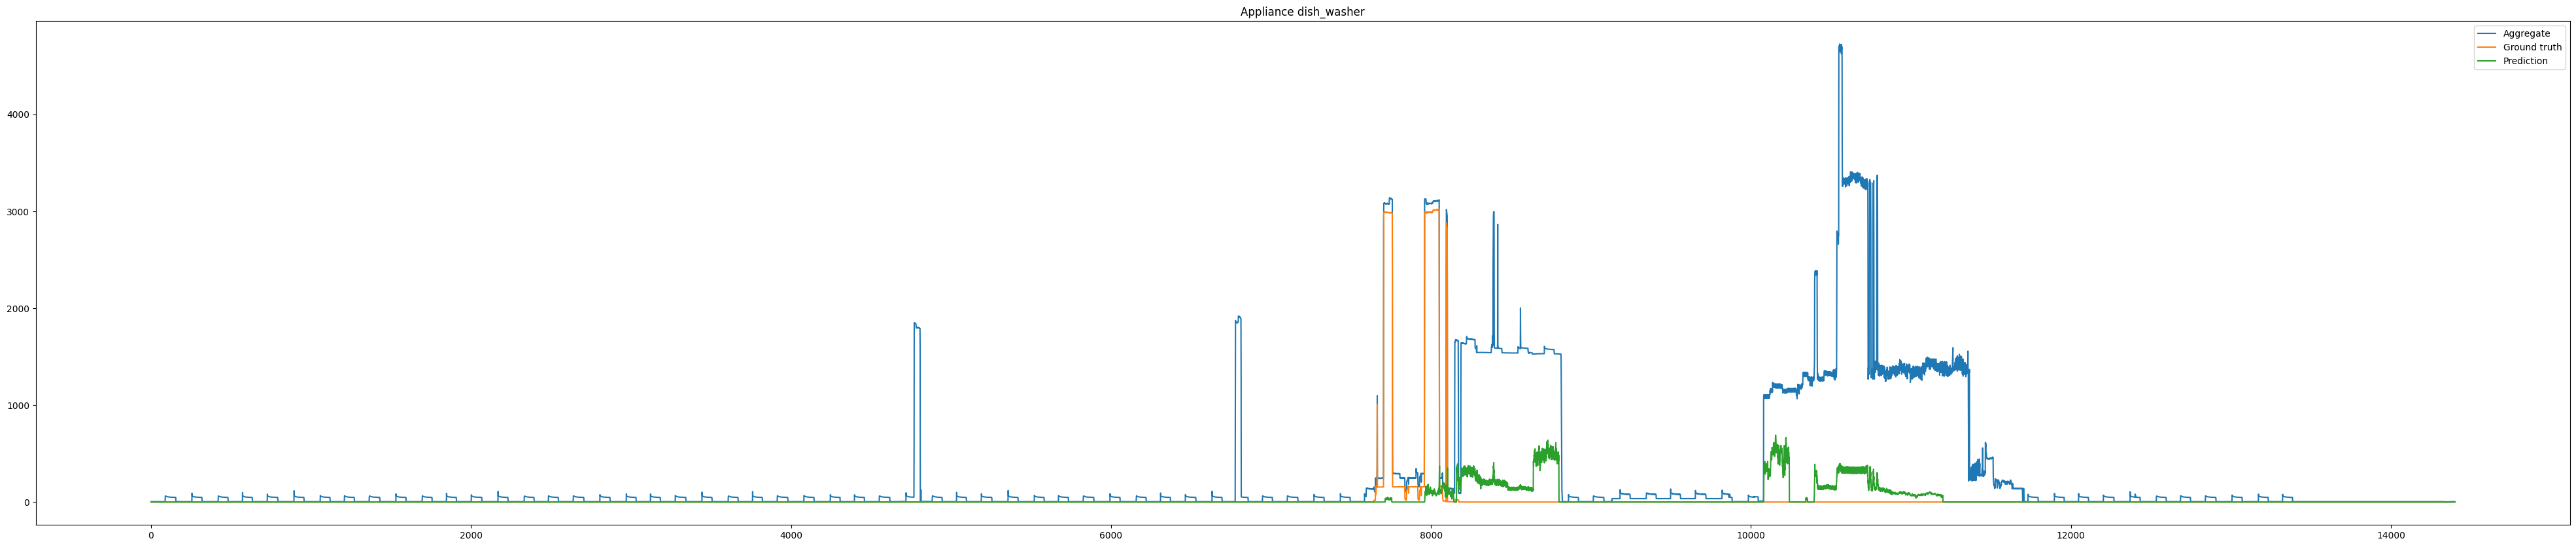

In [15]:
log_data_and_images('./logs/logs_BERT4NILM', x,energy[:14400], y[:14400], 1/6, ['dish_washer'], args_dict,show=True)

505400.6623133333
408892.70679473877


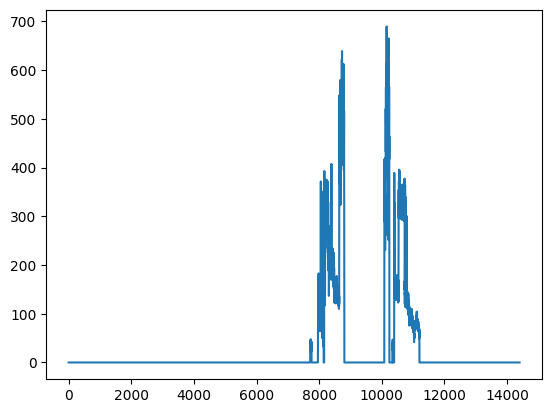

In [16]:
# plt.figure(figsize=(50, 10))


# plt.plot(range(14400), x[:14400], label='Aggregate')
# plt.plot(range(14400), y[:14400], label='Ground truth')
plt.plot(range(14400), energy[:14400], label='Prediction')
# plt.legend()
# plt.show()
# plt.figure(figsize=(50, 10))

# del model
print(np.sum(y[:14400]))
print(np.sum(energy[:14400]))
